In general, if df is a Pandas object (such as a dataframe or series), then the Python command df.x(y, w=z) becomes x(df, y, w=z) in Julia. df.loc[a,b,c] becomes loc(df)[a,b,c] (same for iloc and ix). 

In [16]:
import Pkg
using Pkg
Pkg.add("Distributions")
Pkg.add("BlackBoxOptim")
Pkg.add("ForwardDiff")
Pkg.add("Optim")
Pkg.add("HTTP")
Pkg.add("DataFrames")
Pkg.add("Pandas")
Pkg.add("Plots")
using Distributions, BlackBoxOptim, ForwardDiff, Optim, HTTP, DataFrames, Pandas, Plots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Chan

In [17]:
# StatsPlots and Pandas conflict so if we want to use StatsPlots write plt.plot()
import StatsPlots; plt=StatsPlots
import Pandas; pd=Pandas;

In [18]:
dataset = read_csv("datamerged2.csv");

In [19]:
subset1 = query(dataset,("treatment==1 and (round==2 or round==3)"));

In [20]:
describe(subset1)

,id,treatment,tofrom,value,role,resp,round,rounds,old
count,422.000000,422.0,422.000000,422.000000,422.0,422.000000,422.000000,422.000000,422.000000
mean,124.805687,1.0,135.838863,20.284550,0.0,0.819905,2.177725,2.355450,0.867299
std,81.297525,0.0,85.181224,6.608621,0.0,0.384722,0.382735,0.479218,0.676319
min,1.000000,1.0,6.000000,4.200000,0.0,0.000000,2.000000,2.000000,0.000000
25%,25.000000,1.0,28.000000,15.000000,0.0,1.000000,2.000000,2.000000,0.000000
50%,152.000000,1.0,167.000000,20.000000,0.0,1.000000,2.000000,2.000000,1.000000
75%,162.000000,1.0,177.000000,25.000000,0.0,1.000000,2.000000,3.000000,1.000000
max,250.000000,1.0,274.000000,45.000000,0.0,1.000000,3.000000,3.000000,2.000000


In [21]:
# Distribution of our loss aversion paramters
# Initial guess is a Truncated Normal Distribution with(mean=3, std=1, lb=1, ub=inf)
F = TruncatedNormal(3,1,1,Inf);

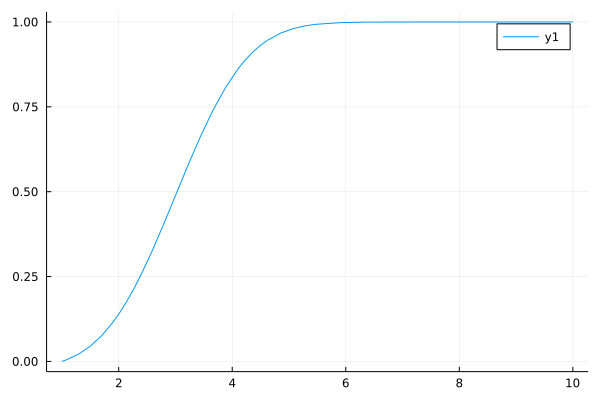

In [22]:
plt.plot(x -> cdf(F,x),1,10)

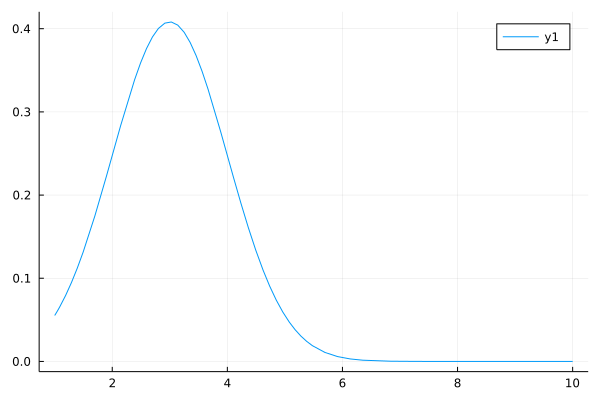

In [23]:
plt.plot(x -> pdf(F,x),1,10)

In [24]:
#probability loss aversion param below 2.5 given mean and std
cdf(F,2.5)

0.29244046596551004

In [25]:
#likelihood of seeing a loss aversion param of 2.5 given mean and std
pdf(F,2.5)

0.3602613193145302

### Finding G($\lambda$) aka F in our code

In [26]:
# Offers in vector form, divided by 55 to get the offer share
s = (values(subset1["value"])/55);

In [27]:
#parameters
alph = .2 #competitiveness term
r = 5/55; #reference offer (close to the minimum offer share observed in the data)

In [28]:
#x = (r-s.5)/r
x = zeros(0)
for i in s
    append!(x,(r-i+.5)/r)
end
x[1]

2.5

In [29]:
Q = ones(422)-cdf(F,x)
Q[1]

0.70755953403449

In [30]:
dQ = zeros(0)
for i in x
    append!(dQ,pdf(F,i))
end
dQ[1]

0.3602613193145302

$$
\lambda = \frac{2Q(s)(1+2\alpha)}{Q^\prime(s)} - 2(1-s(1+2\alpha)) + 1 
$$

In [31]:
lambda = zeros(0)
for i in s
    append!(lambda,(((2*(1 - cdf(F,(r-i+.5)/r)))*(1 + 2*alph))/pdf(F,(r-i+.5)/r) - 2*(1 - i*(1 + 2*alph)) + 1))
end
lambda

422-element Vector{Float64}:
  5.517430805184199
  5.517430805184199
  5.517430805184199
  5.517430805184199
  5.517430805184199
  5.517430805184199
  5.517430805184199
  5.517430805184199
  2.619690177323489
  2.619690177323489
  2.619690177323489
  2.619690177323489
  2.619690177323489
  ⋮
  5.517430805184199
  5.517430805184199
  5.517430805184199
  5.517430805184199
  5.517430805184199
  5.517430805184199
 20.447127693096665
 20.447127693096665
 20.447127693096665
 Inf
 41.82177341101033
  5.517430805184199

### Log Likelihood Estimation

In [45]:
#Haven't quite figured out what to do yet, what are we comparing our distribution of lambdas to?
function LL(params,offers)
    F = TruncatedNormal(params[1],params[2],1,Inf)
    lambda=zeros(0)
    loglike=0
    for i in offers
        append!(lambda,(((2*(1 - cdf(F,(r-i+.5)/r)))*(1 + 2*alph))/pdf(F,(r-i+.5)/r) - 2*(1 - i*(1 + 2*alph)) + 1))
    end
    for i in lambda
        loglike = loglike+log(pdf(F,i))
    end
    return -loglike
    end

LL (generic function with 1 method)

In [46]:
res = optimize(params -> LL(params, s), [3, 0.2])

 * Status: success

 * Candidate solution
    Final objective value:     Inf

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    0
    f(x) calls:    4


In [41]:
show(LL([3,1],s))

LoadError: ArgumentError: invalid index: 5.517430805184199 of type Float64

In [ ]:
show(l([.3,.2],data))

In [47]:
pair = Optim.minimizer(res)

2-element Vector{Float64}:
 3.0
 0.2

In [ ]:
best = TruncatedNormal(pair[1],pair[2],0,1)